In [ ]:
import h5py
import numpy as np

In [ ]:
!pip install hdf5storage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.4 MB/s 


In [ ]:
import hdf5storage
mat = hdf5storage.loadmat('/content/drive/MyDrive/Brain_image_dataset/8.mat')

In [ ]:
pic  = mat['cjdata']['image']

pic = np.array(pic)

print(pic.shape)

(1, 512, 512)


In [ ]:
print(mat['cjdata']['label'])
print(np.array(mat['cjdata']['label'])[0][0][0])

[[[1.]]]
1.0


In [ ]:
import matplotlib.pyplot as plt

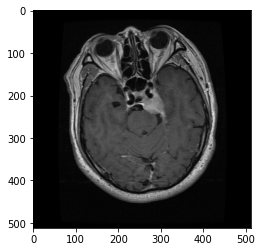

In [ ]:
img = np.resize(pic, (512,512))
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
train_imgs = []
train_masks = []

for i in range (0,3064):
  mat = hdf5storage.loadmat('/content/drive/MyDrive/Brain_image_dataset/'+str(i+1)+'.mat')
  if(np.array(mat['cjdata']['label'])[0][0][0]==3):

    pic  = mat['cjdata']['image']
    pic = np.array(pic)
    if(pic.shape == (1,512,512)):
      train_imgs.append(pic)
    pic  = mat['cjdata']['tumorMask']
    pic = np.array(pic)
    if(pic.shape == (1,512,512)):
     pic = pic.astype(np.float32)
     train_masks.append(pic)

In [ ]:
train_imgs = np.array(train_imgs)
train_masks = np.array(train_masks)
train_imgs.shape

(915, 1, 512, 512)

In [ ]:
train_imgs = np.reshape(train_imgs,(915,512,512,1))
train_imgs.shape

(915, 512, 512, 1)

In [ ]:
train_masks = np.reshape(train_masks,(915,512,512,1))
train_masks.shape

(915, 512, 512, 1)

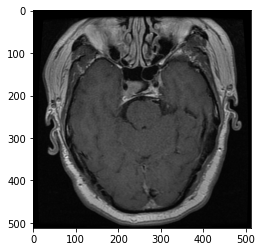

In [ ]:
plt.imshow(np.squeeze(train_imgs[1]), cmap='gray')
plt.show()

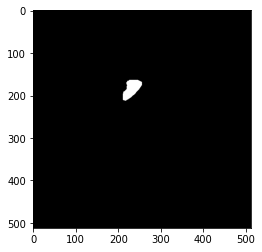

In [ ]:
plt.imshow(np.squeeze(train_masks[1]), cmap='gray')
plt.show()

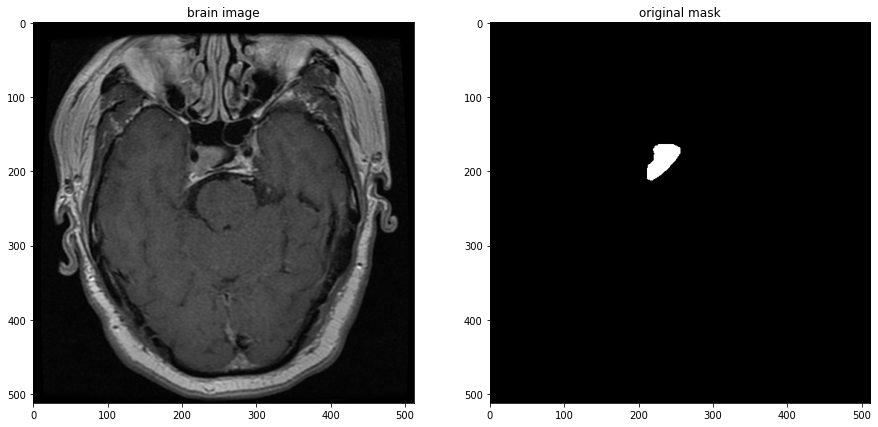

In [ ]:
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(train_imgs[1]), cmap='gray')
plt.title('brain image')
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(train_masks[1]), cmap='gray')
plt.title('original mask')


plt.show()

In [ ]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.models import Model

In [ ]:
inputs = Input((512, 512, 1))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

In [ ]:
from tensorflow.python.client import device_lib;print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3694694788141177011
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14180688679390190633
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 1)  4          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['batch_normalization[0][0]']    
                                )                                                             

In [ ]:
from keras import backend as K
from keras.losses import binary_crossentropy

SMOOTH = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (K.sum(y_true_f) + K.sum(y_pred_f) + SMOOTH)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(Adam(lr=1e-4),
              bce_dice_loss,
              metrics=[binary_crossentropy, dice_coef])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
val_imgs = train_imgs[651:837]
val_imgs.shape

(186, 512, 512, 1)

In [ ]:
val_masks = train_masks[651:837]
val_masks.shape

(186, 512, 512, 1)

In [ ]:
hist = model.fit(train_imgs[:651], train_masks[:651],
          batch_size=12, epochs=50, 
          validation_data=(val_imgs, val_masks))

Epoch 1/50
55/55 [==============================] - 83s 1s/step - loss: 0.1679 - binary_crossentropy: 0.3620 - dice_coef: 0.0132 - val_loss: 0.0545 - val_binary_crossentropy: 0.1202 - val_dice_coef: 0.0055
Epoch 2/50
55/55 [==============================] - 54s 992ms/step - loss: 0.0116 - binary_crossentropy: 0.0627 - dice_coef: 0.0198 - val_loss: 0.0235 - val_binary_crossentropy: 0.0791 - val_dice_coef: 0.0157
Epoch 3/50
55/55 [==============================] - 54s 988ms/step - loss: -0.0155 - binary_crossentropy: 0.0590 - dice_coef: 0.0468 - val_loss: 0.0234 - val_binary_crossentropy: 0.0931 - val_dice_coef: 0.0235
Epoch 4/50
55/55 [==============================] - 55s 993ms/step - loss: -0.1465 - binary_crossentropy: 0.0659 - dice_coef: 0.1823 - val_loss: -0.2190 - val_binary_crossentropy: 0.0640 - val_dice_coef: 0.2476
Epoch 5/50
55/55 [==============================] - 55s 993ms/step - loss: -0.4018 - binary_crossentropy: 0.0603 - dice_coef: 0.4335 - val_loss: -0.4494 - val_binar

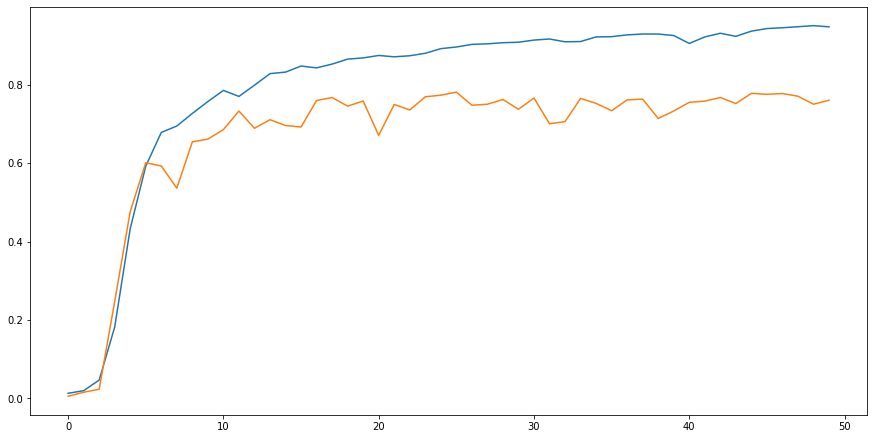

In [ ]:
plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.show()

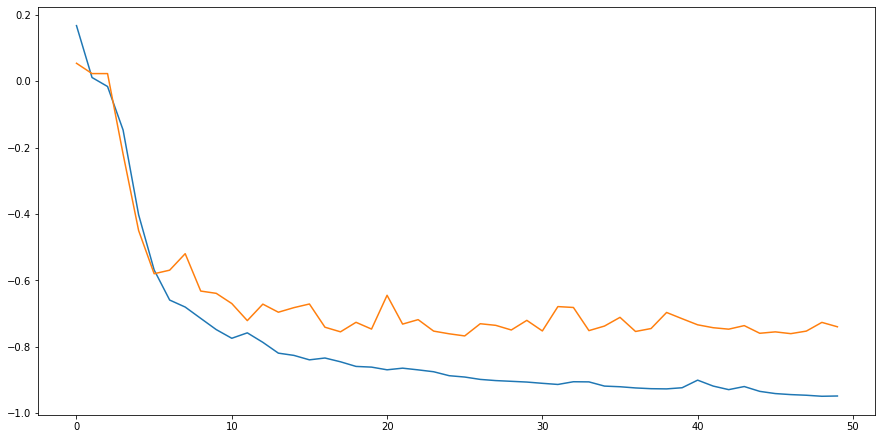

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Bio_DP/saved_model_05/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Bio_DP/saved_model_05/assets


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Bio_DP/saved_model_05/',custom_objects={'dice_coef':dice_coef,'bce_dice_loss':bce_dice_loss})

In [ ]:
test_imgs = train_imgs[837:]
test_masks = train_masks[837:]

In [ ]:
results = model.evaluate(test_imgs, test_masks, batch_size=12)

7/7 [==============================] - 3s 264ms/step - loss: -0.7637 - binary_crossentropy: 0.0293 - dice_coef: 0.7887


In [ ]:
img = train_imgs[640]
pred_mask = model.predict(np.reshape(img,(1,512,512,1)))

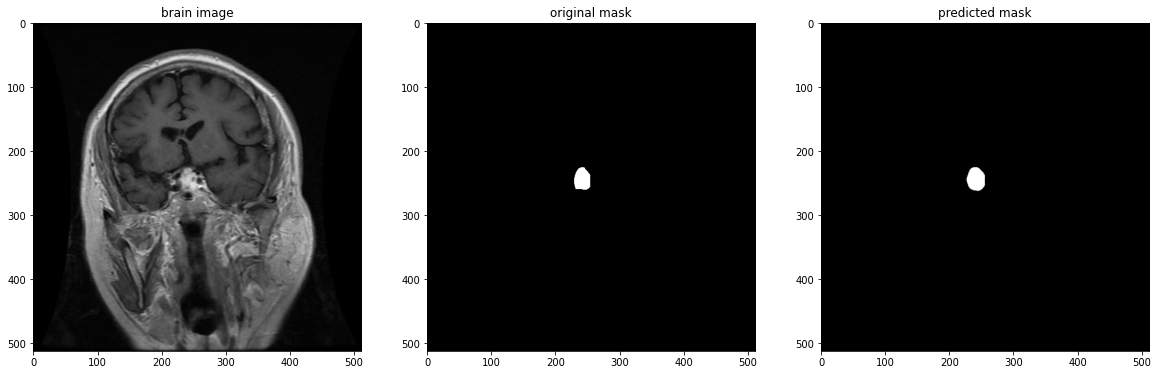

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(train_imgs[640]), cmap='gray')
plt.title('brain image')
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(train_masks[640]), cmap='gray')
plt.title('original mask')
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(pred_mask), cmap='gray')
plt.title('predicted mask')
plt.show()